In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from PIL import Image

# Set random seeds to ensure the reproducible results
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Data loading and preprocessing

In [3]:
# dataset for training model
#data_dir = '/content/drive/My Drive/app/traindata/'
data_dir = '/content/drive/My Drive/app/traindata_with_extra_images/'

# the directory to store model
model_save_dir = '/content/drive/My Drive/app/'

# testdata directory
testdata_dir = '/content/drive/My Drive/app/testdata'

In [4]:
# use data augmentation to create more instance to train and validate the model
# use split parameter to spilt the data into the training and validation
batch_size=32
# Our original images consist in RGB coefficients in the 0-255, but such values
# would be too high for our model to process (given a typical learning rate),
# so we target values between 0 and 1 instead by scaling with a 1/255.
train_datagen = ImageDataGenerator(validation_split=0.2,
                                 rescale=1./255,
                                 rotation_range=30,
                                 shear_range= 0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

# Normalize the test data images, resize them but don't augment them, to eliminate the
# uncertainty of testing results.
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

# testdataset
testdata_gen = ImageDataGenerator(rescale=1./255)

# load the data from the training directory and set them to two flows training /validation
train = train_datagen.flow_from_directory(data_dir, target_size=(300,300), shuffle=True,
                                          classes=['cherry','strawberry','tomato'],
                                          batch_size=batch_size, subset='training')

test = validation_datagen.flow_from_directory(data_dir, target_size=(300,300), shuffle=True,
                                              batch_size=batch_size, subset='validation')

testdata = testdata_gen.flow_from_directory(testdata_dir, target_size=(300,300),
                                            batch_size=1)

Found 5818 images belonging to 3 classes.
Found 1453 images belonging to 3 classes.
Found 148 images belonging to 3 classes.


In [ ]:
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/app/CNN_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EDA

In [ ]:
# List the classes and their encoded number
train.class_indices

{'cherry': 0, 'strawberry': 1, 'tomato': 2}

In [ ]:
# Provided dataset distribution after remove noise/irrelavent images
class_list_1 = []
print('Training Data')
for direc in os.listdir('/content/drive/My Drive/app/traindata/'):
    print(direc, ':',len(os.listdir('/content/drive/My Drive/app/traindata/'+direc)))
    class_list_1.append(direc)

Training Data
strawberry : 1474
tomato : 1424
cherry : 1461


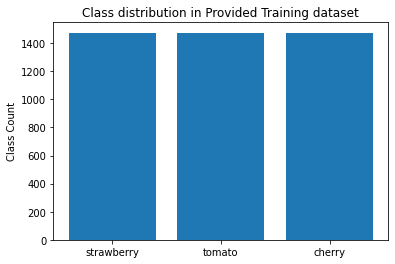

In [ ]:
plt.bar(class_list_1, len(os.listdir('/content/drive/My Drive/app/traindata/'+direc)))
plt.ylabel('Class Count')
plt.title('Class distribution in Provided Training dataset')
plt.show()

In [ ]:
# Provided + downloadede dataset distribution after remove noise/irrelavent images
class_list_2 = []
print('Training Data')
for direc in os.listdir('/content/drive/My Drive/app/traindata_with_extra_images/'):
    print(direc, ':',len(os.listdir('/content/drive/My Drive/app/traindata_with_extra_images/'+direc)))
    class_list_2.append(direc)

Training Data
cherry : 2420
tomato : 2424
strawberry : 2427


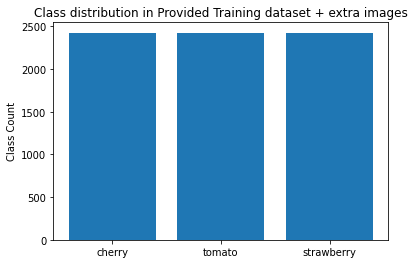

In [ ]:
plt.bar(class_list_2, len(os.listdir('/content/drive/My Drive/app/traindata_with_extra_images/'+direc)))
plt.ylabel('Class Count')
plt.title('Class distribution in Provided Training dataset + extra images')
plt.show()

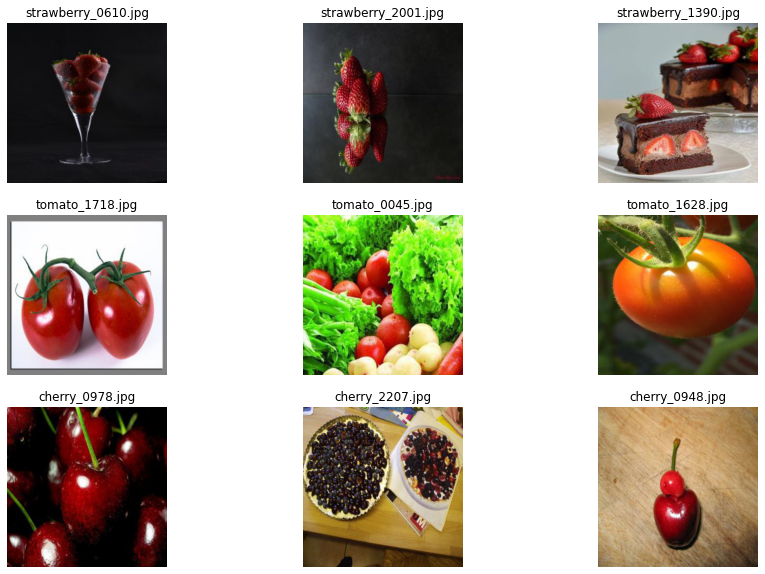

In [ ]:
# Display the data in the training set

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15,10, forward=True)

disp_images = []
row = 0
for direc in os.listdir(data_dir):
    img_path = os.listdir(data_dir + direc)
    for i in range(3):
        img = Image.open(data_dir + direc + '/' + img_path[i])
        axs[row, i].imshow(img)
        axs[row, i].set_title(img_path[i])
        axs[row, i].axis('off')
    row += 1
plt.show()

Functions of training, evaluating and saving the models

In [ ]:
# function of training the model
def train_model(model):
  history = model.fit(train, validation_data = test, epochs = 50, verbose = 1)
  
  # adding callbacks to prevent overfitting
  #history = model.fit(train, validation_data = test, epochs = 100, verbose = 1, callbacks=[earlyStop,checkPoint])
  return history, model

In [ ]:
# function of evaluating the model
def evaluate_model(history_model):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history_model.history['val_accuracy'], 'tab:orange', label='val_acc')
    ax1.plot(history_model.history['accuracy'], 'tab:blue', label='acc')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Val_Accuracy')
    ax1.set_xlabel('Number of epoch')

    ax2.plot(history_model.history['val_loss'], 'tab:orange', label='val_loss')
    ax2.plot(history_model.history['loss'], 'tab:blue', label='loss')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylabel('Val_Loss')
    ax2.set_xlabel('Number of epoch')
    return plt.show()

In [ ]:
# function of saving the model
def save_model(model,name):
    #Save the keras model for later evaluation
    path = model_save_dir + name + '.h5'
    model.save(path)
    print("Model Saved Successfully.")

Build MLP model

In [ ]:
# build a simple baseline model
def build_MLP_model():
    model = Sequential()
    # layer 1
    model.add(Flatten(input_shape = (300, 300, 3)))
    model.add(Dense(256, activation='relu'))
    # layer 2
    model.add(Dense(128, activation='relu'))
    # layer 3
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
MLP_model = build_MLP_model()
MLP_model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 270000)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 256)               69120256  
_________________________________________________________________
dense_50 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 387       
Total params: 69,153,539
Trainable params: 69,153,539
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train MLP model
history_MLP, MLP_model_save = train_model(MLP_model)

Epoch 1/50
108/108 [==============================] - 76s 698ms/step - loss: 20.2032 - accuracy: 0.3768 - val_loss: 7.5803 - val_accuracy: 0.3508
Epoch 2/50
108/108 [==============================] - 74s 687ms/step - loss: 6.1171 - accuracy: 0.4139 - val_loss: 5.8182 - val_accuracy: 0.3264
Epoch 3/50
108/108 [==============================] - 74s 682ms/step - loss: 4.6537 - accuracy: 0.4020 - val_loss: 2.3166 - val_accuracy: 0.4878
Epoch 4/50
108/108 [==============================] - 74s 681ms/step - loss: 2.4441 - accuracy: 0.4287 - val_loss: 2.3177 - val_accuracy: 0.3972
Epoch 5/50
108/108 [==============================] - 73s 678ms/step - loss: 1.8603 - accuracy: 0.4530 - val_loss: 1.2205 - val_accuracy: 0.4669
Epoch 6/50
108/108 [==============================] - 73s 680ms/step - loss: 1.3178 - accuracy: 0.4655 - val_loss: 1.2168 - val_accuracy: 0.4111
Epoch 7/50
108/108 [==============================] - 73s 677ms/step - loss: 1.2483 - accuracy: 0.4696 - val_loss: 1.1961 - val_a

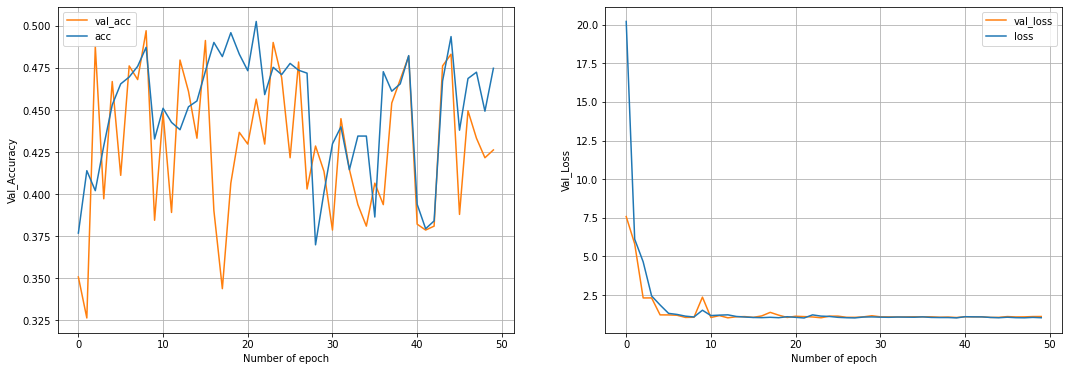

In [ ]:
# Evaluate MLP model
evaluate_model(history_MLP)

In [ ]:
save_model(MLP_model_save,'MLP_model')

Model Saved Successfully.


Build CNN model

In [ ]:
# Build a basic CNN model
def build_basic_CNN_model():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu'))
     # layer 5
     model.add(Dense(3, activation='softmax'))
     
     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
     return model

In [ ]:
basic_CNN_model = build_basic_CNN_model()
basic_CNN_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 156800)           

In [ ]:
# train basic CNN model
history_basic_CNN, basic_CNN_model_save = train_model(basic_CNN_model)

Epoch 1/50
110/110 [==============================] - 248s 2s/step - loss: 1.1150 - accuracy: 0.4293 - val_loss: 0.9645 - val_accuracy: 0.5080
Epoch 2/50
110/110 [==============================] - 77s 698ms/step - loss: 0.9975 - accuracy: 0.4904 - val_loss: 0.9849 - val_accuracy: 0.4943
Epoch 3/50
110/110 [==============================] - 77s 699ms/step - loss: 0.9318 - accuracy: 0.5555 - val_loss: 0.8735 - val_accuracy: 0.6046
Epoch 4/50
110/110 [==============================] - 77s 701ms/step - loss: 0.8740 - accuracy: 0.6019 - val_loss: 0.8784 - val_accuracy: 0.5851
Epoch 5/50
110/110 [==============================] - 77s 700ms/step - loss: 0.8254 - accuracy: 0.6495 - val_loss: 0.8430 - val_accuracy: 0.6230
Epoch 6/50
110/110 [==============================] - 78s 708ms/step - loss: 0.7544 - accuracy: 0.6864 - val_loss: 0.6714 - val_accuracy: 0.7345
Epoch 7/50
110/110 [==============================] - 77s 699ms/step - loss: 0.6798 - accuracy: 0.7200 - val_loss: 0.6944 - val_accu

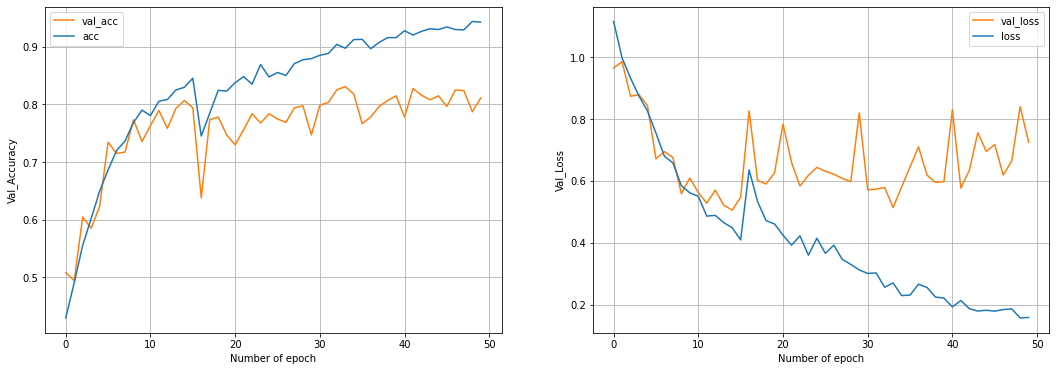

In [ ]:
# Evaluate basic CNN model
evaluate_model(history_basic_CNN)

Optimize CNN model

In [ ]:
# apply dropout 0.25 to each layers except for last one
def build_tuned_CNN_model():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu'))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
model = build_tuned_CNN_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 128)      

In [ ]:
history_CNN_tuned, CNN_tuned_model = train_model(model)

Epoch 1/50
71/71 [==============================] - 74s 1s/step - loss: 1.4192 - accuracy: 0.3687 - val_loss: 1.0666 - val_accuracy: 0.4120
Epoch 2/50
71/71 [==============================] - 72s 1s/step - loss: 1.0106 - accuracy: 0.4783 - val_loss: 1.0301 - val_accuracy: 0.4977
Epoch 3/50
71/71 [==============================] - 72s 1s/step - loss: 0.9542 - accuracy: 0.5400 - val_loss: 0.9821 - val_accuracy: 0.5181
Epoch 4/50
71/71 [==============================] - 71s 1s/step - loss: 0.9500 - accuracy: 0.5409 - val_loss: 0.9439 - val_accuracy: 0.5542
Epoch 5/50
71/71 [==============================] - 71s 1000ms/step - loss: 0.9197 - accuracy: 0.5750 - val_loss: 0.9136 - val_accuracy: 0.5971
Epoch 6/50
71/71 [==============================] - 72s 1s/step - loss: 0.8924 - accuracy: 0.5975 - val_loss: 0.9212 - val_accuracy: 0.6185
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 0.8753 - accuracy: 0.6017 - val_loss: 0.9225 - val_accuracy: 0.6005
Epoch 8/50
71/71

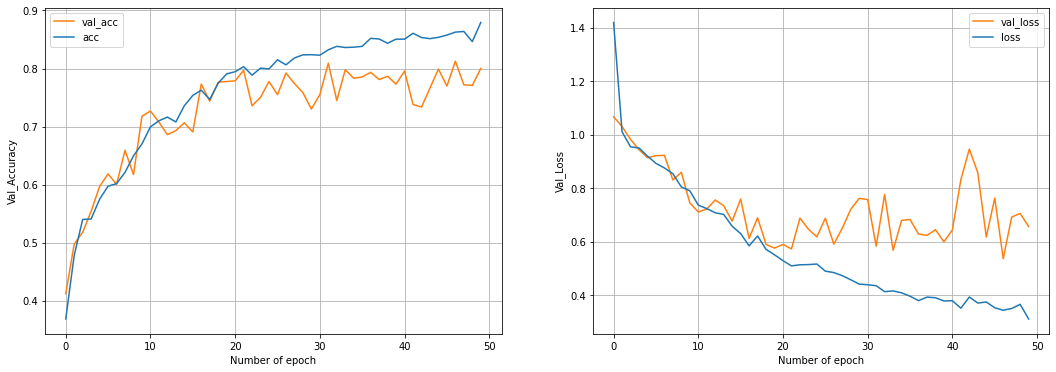

In [ ]:
# evaluate tuned CNN model
evaluate_model(history_CNN_tuned)

In [ ]:
# apply dropout 0.25 to each layers except for last one
# apply regulizer L1 = 0.01 to the three layers with the highest parameters.
def build_tuned_CNN_model_1():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l1(0.01)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_1 = build_tuned_CNN_model_1()
CNN_model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 71, 71, 128)      

In [ ]:
history_CNN_tuned_1, CNN_tuned_model_1 = train_model(CNN_model_1)

Epoch 1/50
71/71 [==============================] - 75s 1s/step - loss: 50.1242 - accuracy: 0.3382 - val_loss: 15.9135 - val_accuracy: 0.3330
Epoch 2/50
71/71 [==============================] - 74s 1s/step - loss: 14.3560 - accuracy: 0.3143 - val_loss: 13.9079 - val_accuracy: 0.3330
Epoch 3/50
71/71 [==============================] - 74s 1s/step - loss: 13.7717 - accuracy: 0.3258 - val_loss: 13.4299 - val_accuracy: 0.3330
Epoch 4/50
71/71 [==============================] - 74s 1s/step - loss: 13.7207 - accuracy: 0.3233 - val_loss: 13.5032 - val_accuracy: 0.3330
Epoch 5/50
71/71 [==============================] - 73s 1s/step - loss: 13.7218 - accuracy: 0.3176 - val_loss: 13.8098 - val_accuracy: 0.3341
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 13.7239 - accuracy: 0.3272 - val_loss: 13.8241 - val_accuracy: 0.3341
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 13.7258 - accuracy: 0.3250 - val_loss: 13.6640 - val_accuracy: 0.3341
Epoch 

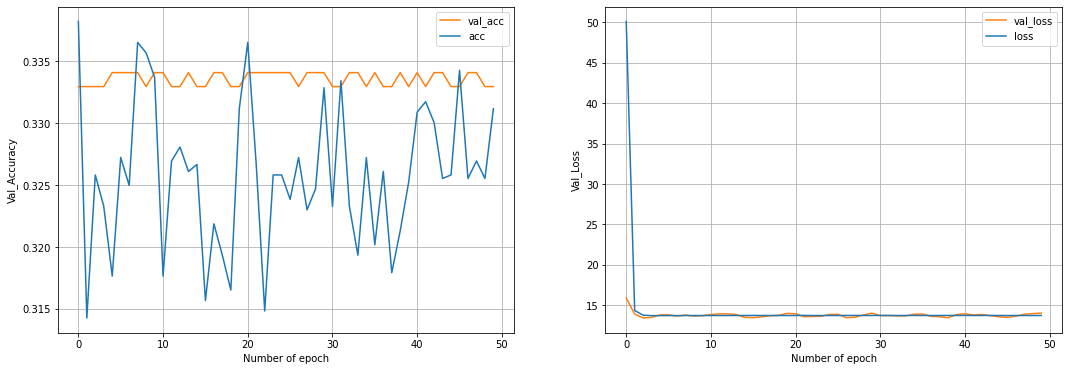

In [ ]:
# evaluate CNN tuned model 1
evaluate_model(history_CNN_tuned_1)

In [ ]:
# apply dropout 0.25 to each layers except for last one
# apply regulizer L2 = 0.01 to the three layers with the highest parameters.
def build_tuned_CNN_model_2():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_2 = build_tuned_CNN_model_2()
CNN_model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 71, 71, 128)     

In [ ]:
history_CNN_tuned_2, CNN_tuned_model_2 = train_model(CNN_model_2)

Epoch 1/50
71/71 [==============================] - 74s 1s/step - loss: 3.4551 - accuracy: 0.3461 - val_loss: 2.1697 - val_accuracy: 0.3330
Epoch 2/50
71/71 [==============================] - 72s 1s/step - loss: 1.8790 - accuracy: 0.4228 - val_loss: 1.6720 - val_accuracy: 0.5011
Epoch 3/50
71/71 [==============================] - 72s 1s/step - loss: 1.5586 - accuracy: 0.4870 - val_loss: 1.4714 - val_accuracy: 0.5158
Epoch 4/50
71/71 [==============================] - 71s 1s/step - loss: 1.4195 - accuracy: 0.4983 - val_loss: 1.3518 - val_accuracy: 0.4808
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.3051 - accuracy: 0.5020 - val_loss: 1.2562 - val_accuracy: 0.5226
Epoch 6/50
71/71 [==============================] - 72s 1s/step - loss: 1.2355 - accuracy: 0.5101 - val_loss: 1.2040 - val_accuracy: 0.5339
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 1.1882 - accuracy: 0.5099 - val_loss: 1.1584 - val_accuracy: 0.5463
Epoch 8/50
71/71 [==

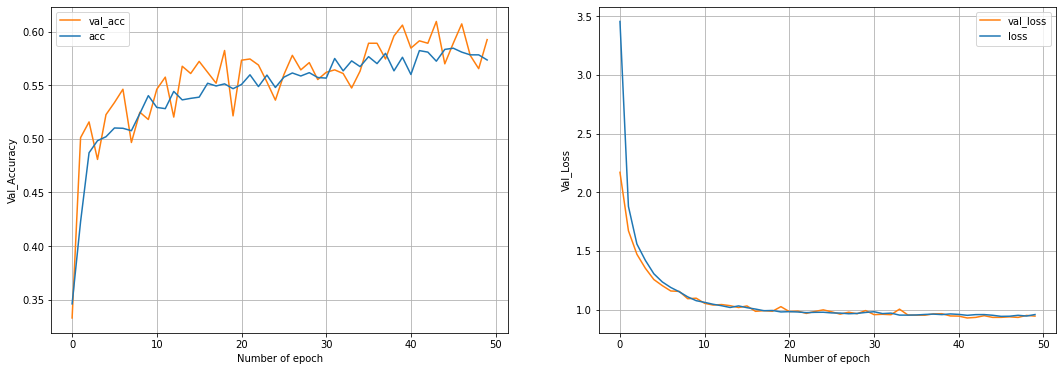

In [ ]:
# evaluate CNN tuned model 2
evaluate_model(history_CNN_tuned_2)

In [ ]:
# apply dropout 0.25 to each layers except for last one
# apply regulizer L2 = 0.001 to the three layers with the highest parameters.
def build_tuned_CNN_model_3():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_3 = build_tuned_CNN_model_3()
CNN_model_3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 71, 71, 128)     

In [ ]:
history_CNN_tuned_3, CNN_tuned_model_3 = train_model(CNN_model_3)

Epoch 1/50
71/71 [==============================] - 74s 1s/step - loss: 1.7155 - accuracy: 0.3405 - val_loss: 1.3211 - val_accuracy: 0.3758
Epoch 2/50
71/71 [==============================] - 73s 1s/step - loss: 1.2821 - accuracy: 0.3334 - val_loss: 1.2495 - val_accuracy: 0.3330
Epoch 3/50
71/71 [==============================] - 74s 1s/step - loss: 1.2311 - accuracy: 0.3393 - val_loss: 1.2053 - val_accuracy: 0.4368
Epoch 4/50
71/71 [==============================] - 74s 1s/step - loss: 1.1680 - accuracy: 0.4326 - val_loss: 1.1272 - val_accuracy: 0.5214
Epoch 5/50
71/71 [==============================] - 74s 1s/step - loss: 1.0837 - accuracy: 0.5048 - val_loss: 1.0773 - val_accuracy: 0.5237
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 1.0587 - accuracy: 0.5166 - val_loss: 1.0710 - val_accuracy: 0.5361
Epoch 7/50
71/71 [==============================] - 74s 1s/step - loss: 1.0330 - accuracy: 0.5465 - val_loss: 1.0555 - val_accuracy: 0.5530
Epoch 8/50
71/71 [==

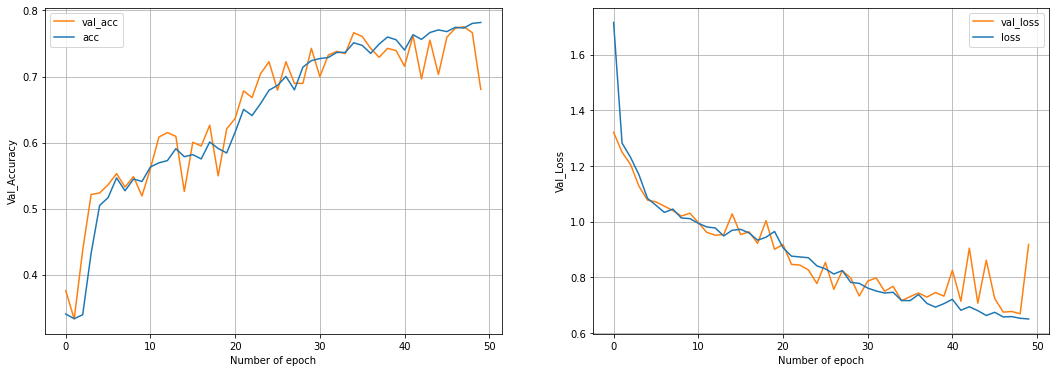

In [ ]:
# evaluate CNN tuned model 3
evaluate_model(history_CNN_tuned_3)

In [ ]:
# apply dropout 0.25 to each layers except for last one
# apply regulizer L2 = 0.1 to the three layers with the highest parameters.
def build_tuned_CNN_model_4():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.1)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_4 = build_tuned_CNN_model_4()
CNN_model_4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 71, 71, 128)     

In [ ]:
history_CNN_tuned_4, CNN_tuned_model_4 = train_model(CNN_model_4)

Epoch 1/50
71/71 [==============================] - 76s 1s/step - loss: 7.7323 - accuracy: 0.3481 - val_loss: 2.4036 - val_accuracy: 0.4074
Epoch 2/50
71/71 [==============================] - 74s 1s/step - loss: 1.6960 - accuracy: 0.3630 - val_loss: 1.3226 - val_accuracy: 0.3330
Epoch 3/50
71/71 [==============================] - 75s 1s/step - loss: 1.2204 - accuracy: 0.3315 - val_loss: 1.1578 - val_accuracy: 0.3330
Epoch 4/50
71/71 [==============================] - 72s 1s/step - loss: 1.1346 - accuracy: 0.3309 - val_loss: 1.1185 - val_accuracy: 0.3341
Epoch 5/50
71/71 [==============================] - 73s 1s/step - loss: 1.1116 - accuracy: 0.3334 - val_loss: 1.1061 - val_accuracy: 0.3341
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 1.1035 - accuracy: 0.3309 - val_loss: 1.1015 - val_accuracy: 0.3341
Epoch 7/50
71/71 [==============================] - 73s 1s/step - loss: 1.1007 - accuracy: 0.3207 - val_loss: 1.0998 - val_accuracy: 0.3330
Epoch 8/50
71/71 [==

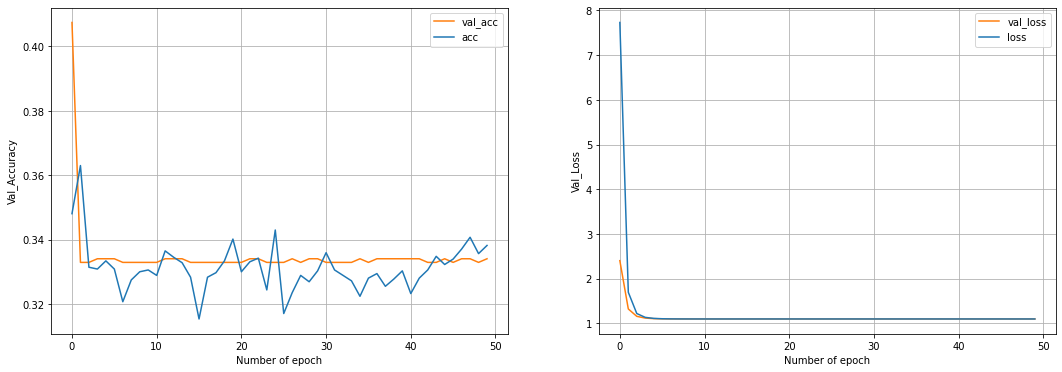

In [ ]:
# evaluate CNN tuned model 4
evaluate_model(history_CNN_tuned_4)

In [ ]:
#  apply dropout 0.25 to each layers except for last one
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  change to apply dropout only to the three layers with the highest parameters
def build_tuned_CNN_model_5():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_5 = build_tuned_CNN_model_5()
CNN_model_5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_5, CNN_tuned_model_5 = train_model(CNN_model_5)

Epoch 1/50
110/110 [==============================] - 80s 717ms/step - loss: 1.3367 - accuracy: 0.4388 - val_loss: 1.2215 - val_accuracy: 0.4379
Epoch 2/50
110/110 [==============================] - 79s 718ms/step - loss: 1.1061 - accuracy: 0.5179 - val_loss: 1.1251 - val_accuracy: 0.4678
Epoch 3/50
110/110 [==============================] - 79s 718ms/step - loss: 1.0513 - accuracy: 0.5305 - val_loss: 1.0082 - val_accuracy: 0.5931
Epoch 4/50
110/110 [==============================] - 78s 705ms/step - loss: 1.0100 - accuracy: 0.5535 - val_loss: 0.9641 - val_accuracy: 0.6126
Epoch 5/50
110/110 [==============================] - 79s 719ms/step - loss: 0.9717 - accuracy: 0.5970 - val_loss: 0.9397 - val_accuracy: 0.6046
Epoch 6/50
110/110 [==============================] - 77s 703ms/step - loss: 0.9172 - accuracy: 0.6366 - val_loss: 0.8409 - val_accuracy: 0.6805
Epoch 7/50
110/110 [==============================] - 77s 696ms/step - loss: 0.9070 - accuracy: 0.6440 - val_loss: 0.8430 - val_ac

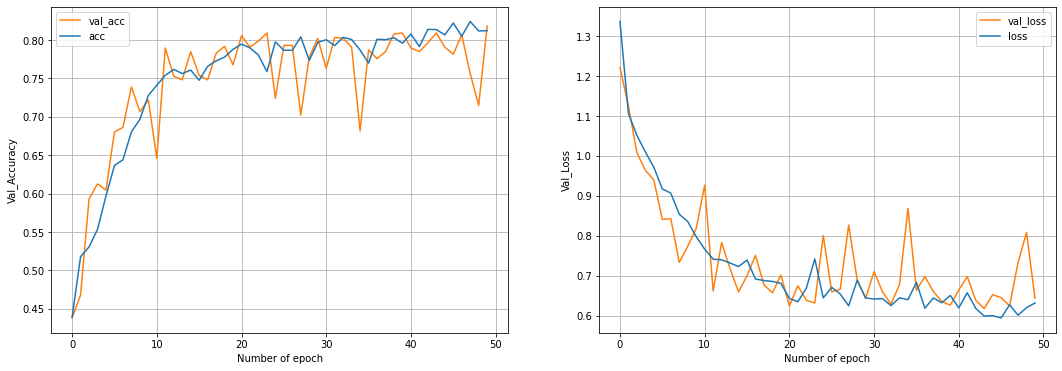

In [ ]:
# evaluate CNN tuned model 5
evaluate_model(history_CNN_tuned_5)

In [ ]:
#  apply dropout 0.25 to each layers except for last one
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  change to apply dropout only to the three layers with the highest parameters
#  apply adam optimizer with learning rate = 0.0001
def build_tuned_CNN_model_6():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     adam = Adam(learning_rate=0.0001)
     model.compile(optimizer=adam, loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_6 = build_tuned_CNN_model_6()
CNN_model_6.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 35, 35, 128)     

In [ ]:
history_CNN_tuned_6, CNN_tuned_model_6 = train_model(CNN_model_6)

Epoch 1/50
71/71 [==============================] - 76s 1s/step - loss: 1.3056 - accuracy: 0.3960 - val_loss: 1.2364 - val_accuracy: 0.5147
Epoch 2/50
71/71 [==============================] - 75s 1s/step - loss: 1.1709 - accuracy: 0.5180 - val_loss: 1.1408 - val_accuracy: 0.5406
Epoch 3/50
71/71 [==============================] - 75s 1s/step - loss: 1.1089 - accuracy: 0.5465 - val_loss: 1.1057 - val_accuracy: 0.5576
Epoch 4/50
71/71 [==============================] - 75s 1s/step - loss: 1.0751 - accuracy: 0.5682 - val_loss: 1.0785 - val_accuracy: 0.5564
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.0542 - accuracy: 0.5634 - val_loss: 1.0576 - val_accuracy: 0.5880
Epoch 6/50
71/71 [==============================] - 75s 1s/step - loss: 1.0349 - accuracy: 0.5778 - val_loss: 1.0268 - val_accuracy: 0.6005
Epoch 7/50
71/71 [==============================] - 75s 1s/step - loss: 1.0028 - accuracy: 0.5879 - val_loss: 1.0114 - val_accuracy: 0.5971
Epoch 8/50
71/71 [==

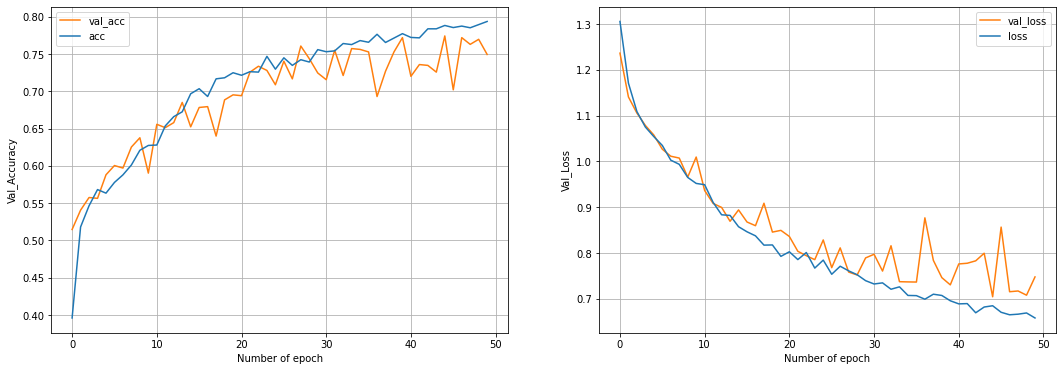

In [ ]:
# evaluate CNN tuned model 6
evaluate_model(history_CNN_tuned_6)

In [ ]:
#  apply dropout 0.25 to each layers except for last one
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  change to apply dropout only to the three layers with the highest parameters
#  apply adam optimizer with learning rate = 0.00001
def build_tuned_CNN_model_7():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     adam = Adam(learning_rate=0.00001)
     model.compile(optimizer=adam, loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_7 = build_tuned_CNN_model_7()
CNN_model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0

In [ ]:
history_CNN_tuned_7, CNN_tuned_model_7 = train_model(CNN_model_7)

Epoch 1/50
71/71 [==============================] - 1345s 19s/step - loss: 1.3537 - accuracy: 0.3455 - val_loss: 1.3419 - val_accuracy: 0.3894
Epoch 2/50
71/71 [==============================] - 75s 1s/step - loss: 1.3323 - accuracy: 0.3760 - val_loss: 1.3313 - val_accuracy: 0.3804
Epoch 3/50
71/71 [==============================] - 75s 1s/step - loss: 1.3175 - accuracy: 0.4061 - val_loss: 1.3156 - val_accuracy: 0.4233
Epoch 4/50
71/71 [==============================] - 75s 1s/step - loss: 1.2997 - accuracy: 0.4276 - val_loss: 1.3036 - val_accuracy: 0.4357
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.2764 - accuracy: 0.4481 - val_loss: 1.3005 - val_accuracy: 0.4074
Epoch 6/50
71/71 [==============================] - 75s 1s/step - loss: 1.2598 - accuracy: 0.4752 - val_loss: 1.2743 - val_accuracy: 0.4357
Epoch 7/50
71/71 [==============================] - 76s 1s/step - loss: 1.2360 - accuracy: 0.4775 - val_loss: 1.2698 - val_accuracy: 0.4424
Epoch 8/50
71/71 

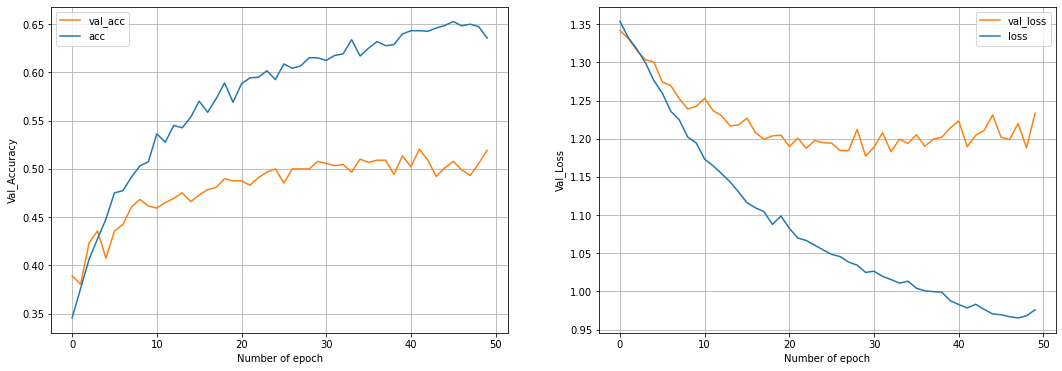

In [ ]:
# evaluate CNN tuned model 7
evaluate_model(history_CNN_tuned_7)

In [ ]:
#  apply dropout 0.25 to each layers except for last one
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  change to apply dropout only to the three layers with the highest parameters
#  apply sgd optimizer
def build_tuned_CNN_model_8():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='sgd', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_8 = build_tuned_CNN_model_8()
CNN_model_8.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_8, CNN_tuned_model_8 = train_model(CNN_model_8)

Epoch 1/50
71/71 [==============================] - 75s 1s/step - loss: 1.3613 - accuracy: 0.3357 - val_loss: 1.3441 - val_accuracy: 0.4221
Epoch 2/50
71/71 [==============================] - 74s 1s/step - loss: 1.3373 - accuracy: 0.3867 - val_loss: 1.3320 - val_accuracy: 0.4244
Epoch 3/50
71/71 [==============================] - 74s 1s/step - loss: 1.3222 - accuracy: 0.4059 - val_loss: 1.3142 - val_accuracy: 0.4142
Epoch 4/50
71/71 [==============================] - 75s 1s/step - loss: 1.3066 - accuracy: 0.4456 - val_loss: 1.2952 - val_accuracy: 0.4752
Epoch 5/50
71/71 [==============================] - 75s 1s/step - loss: 1.2811 - accuracy: 0.4732 - val_loss: 1.2693 - val_accuracy: 0.5113
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 1.2547 - accuracy: 0.4946 - val_loss: 1.2617 - val_accuracy: 0.5079
Epoch 7/50
71/71 [==============================] - 74s 1s/step - loss: 1.2377 - accuracy: 0.5082 - val_loss: 1.2386 - val_accuracy: 0.5350
Epoch 8/50
71/71 [==

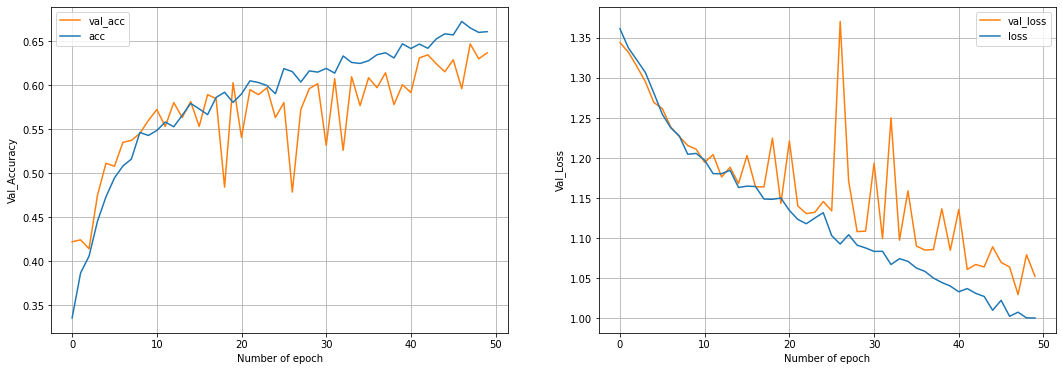

In [ ]:
# evaluate CNN tuned model 8
evaluate_model(history_CNN_tuned_8)

In [ ]:
#  apply dropout 0.25 to each layers except for last one
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  change to apply dropout only to the three layers with the highest parameters
#  apply sgd optimizer with learning_rate = 0.001, momentum = 0.9
def build_tuned_CNN_model_9():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     sgd = SGD(learning_rate = 0.001, momentum=0.9)
     model.compile(optimizer=sgd, loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_9 = build_tuned_CNN_model_9()
CNN_model_9.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_9, CNN_tuned_model_9 = train_model(CNN_model_9)

Epoch 1/50
71/71 [==============================] - 82s 1s/step - loss: 1.3585 - accuracy: 0.3557 - val_loss: 1.3453 - val_accuracy: 0.3950
Epoch 2/50
71/71 [==============================] - 80s 1s/step - loss: 1.3441 - accuracy: 0.3785 - val_loss: 1.3392 - val_accuracy: 0.3860
Epoch 3/50
71/71 [==============================] - 80s 1s/step - loss: 1.3321 - accuracy: 0.4036 - val_loss: 1.3242 - val_accuracy: 0.4673
Epoch 4/50
71/71 [==============================] - 80s 1s/step - loss: 1.3095 - accuracy: 0.4352 - val_loss: 1.3046 - val_accuracy: 0.4819
Epoch 5/50
71/71 [==============================] - 80s 1s/step - loss: 1.2884 - accuracy: 0.4608 - val_loss: 1.2779 - val_accuracy: 0.5237
Epoch 6/50
71/71 [==============================] - 80s 1s/step - loss: 1.2561 - accuracy: 0.5003 - val_loss: 1.2506 - val_accuracy: 0.5282
Epoch 7/50
71/71 [==============================] - 80s 1s/step - loss: 1.2420 - accuracy: 0.5245 - val_loss: 1.2624 - val_accuracy: 0.4842
Epoch 8/50
71/71 [==

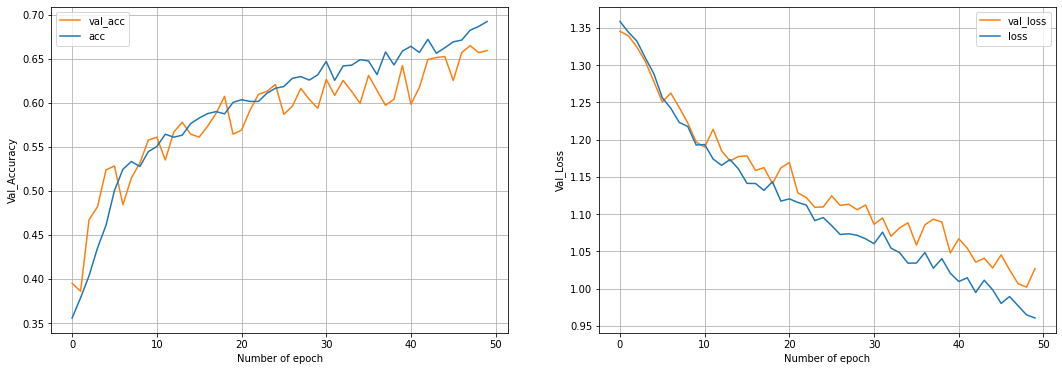

In [ ]:
# evaluate CNN tuned model 9
evaluate_model(history_CNN_tuned_9)

In [ ]:
#  according to the previous tests, the best CNN model is model_5
#  without scaling and preprocessing
def build_tuned_CNN_model_10():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_10 = build_tuned_CNN_model_10()
CNN_model_10.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_10, CNN_tuned_model_10 = train_model(CNN_model_10)

Epoch 1/50
110/110 [==============================] - 384s 3s/step - loss: 28.5343 - accuracy: 0.3528 - val_loss: 1.5900 - val_accuracy: 0.3379
Epoch 2/50
110/110 [==============================] - 14s 129ms/step - loss: 1.5855 - accuracy: 0.3637 - val_loss: 1.5842 - val_accuracy: 0.3356
Epoch 3/50
110/110 [==============================] - 14s 128ms/step - loss: 1.5764 - accuracy: 0.3763 - val_loss: 1.5782 - val_accuracy: 0.3483
Epoch 4/50
110/110 [==============================] - 14s 127ms/step - loss: 1.5453 - accuracy: 0.3972 - val_loss: 1.5851 - val_accuracy: 0.3540
Epoch 5/50
110/110 [==============================] - 14s 129ms/step - loss: 1.5035 - accuracy: 0.4531 - val_loss: 1.5817 - val_accuracy: 0.3713
Epoch 6/50
110/110 [==============================] - 14s 127ms/step - loss: 1.4438 - accuracy: 0.4990 - val_loss: 1.6622 - val_accuracy: 0.4218
Epoch 7/50
110/110 [==============================] - 14s 128ms/step - loss: 1.3845 - accuracy: 0.5552 - val_loss: 1.7612 - val_acc

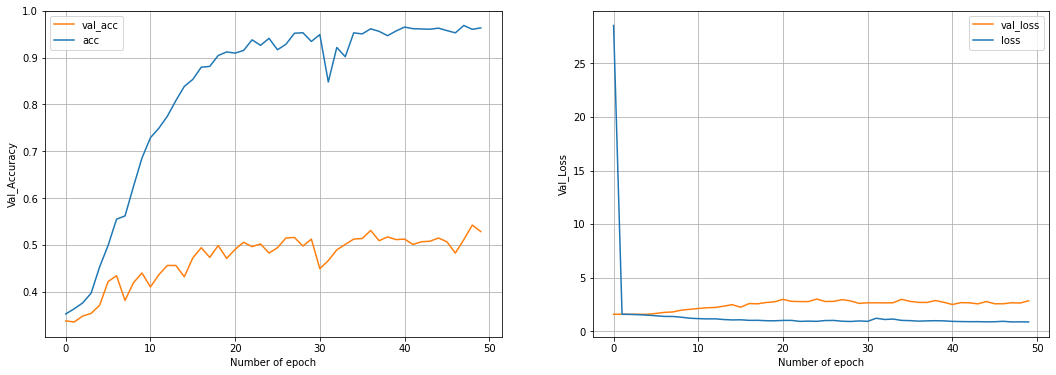

In [ ]:
# evaluate CNN tuned model 10
evaluate_model(history_CNN_tuned_10)

In [ ]:
#  according to the previous tests, the best CNN model is model_5
#  only with scaling
def build_tuned_CNN_model_11():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_11 = build_tuned_CNN_model_11()
CNN_model_11.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_11, CNN_tuned_model_11 = train_model(CNN_model_11)

Epoch 1/50
110/110 [==============================] - 15s 134ms/step - loss: 1.5183 - accuracy: 0.3359 - val_loss: 1.2799 - val_accuracy: 0.3816
Epoch 2/50
110/110 [==============================] - 14s 129ms/step - loss: 1.2017 - accuracy: 0.4228 - val_loss: 1.1216 - val_accuracy: 0.4920
Epoch 3/50
110/110 [==============================] - 14s 129ms/step - loss: 1.0896 - accuracy: 0.4996 - val_loss: 1.0488 - val_accuracy: 0.5195
Epoch 4/50
110/110 [==============================] - 14s 129ms/step - loss: 1.0998 - accuracy: 0.4660 - val_loss: 1.0810 - val_accuracy: 0.5103
Epoch 5/50
110/110 [==============================] - 14s 131ms/step - loss: 1.0460 - accuracy: 0.5113 - val_loss: 1.0141 - val_accuracy: 0.5253
Epoch 6/50
110/110 [==============================] - 14s 129ms/step - loss: 1.0039 - accuracy: 0.5529 - val_loss: 0.9756 - val_accuracy: 0.5379
Epoch 7/50
110/110 [==============================] - 14s 130ms/step - loss: 0.9523 - accuracy: 0.5741 - val_loss: 0.9530 - val_ac

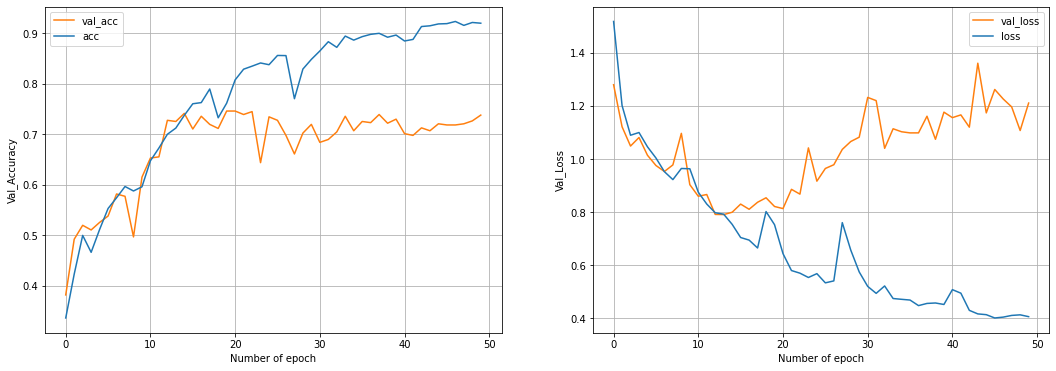

In [ ]:
# evaluate CNN tuned model 11
evaluate_model(history_CNN_tuned_11)

In [ ]:
#  according to the previous tests, the best CNN model is model_5
#  apply scaling and preprocessing
def build_tuned_CNN_model_12():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_12 = build_tuned_CNN_model_12()
CNN_model_12.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 128)      

In [ ]:
history_CNN_tuned_12, CNN_tuned_model_12 = train_model(CNN_model_12)

Epoch 1/50
110/110 [==============================] - 67s 601ms/step - loss: 1.3217 - accuracy: 0.4291 - val_loss: 1.1302 - val_accuracy: 0.5184
Epoch 2/50
110/110 [==============================] - 66s 599ms/step - loss: 1.0951 - accuracy: 0.4999 - val_loss: 1.0851 - val_accuracy: 0.5253
Epoch 3/50
110/110 [==============================] - 66s 598ms/step - loss: 1.0489 - accuracy: 0.5168 - val_loss: 1.0255 - val_accuracy: 0.5333
Epoch 4/50
110/110 [==============================] - 66s 600ms/step - loss: 1.0195 - accuracy: 0.5380 - val_loss: 1.0072 - val_accuracy: 0.5885
Epoch 5/50
110/110 [==============================] - 66s 600ms/step - loss: 0.9897 - accuracy: 0.5540 - val_loss: 0.9703 - val_accuracy: 0.5575
Epoch 6/50
110/110 [==============================] - 66s 598ms/step - loss: 0.9834 - accuracy: 0.5678 - val_loss: 0.9690 - val_accuracy: 0.5621
Epoch 7/50
110/110 [==============================] - 66s 596ms/step - loss: 0.9561 - accuracy: 0.5953 - val_loss: 0.9052 - val_ac

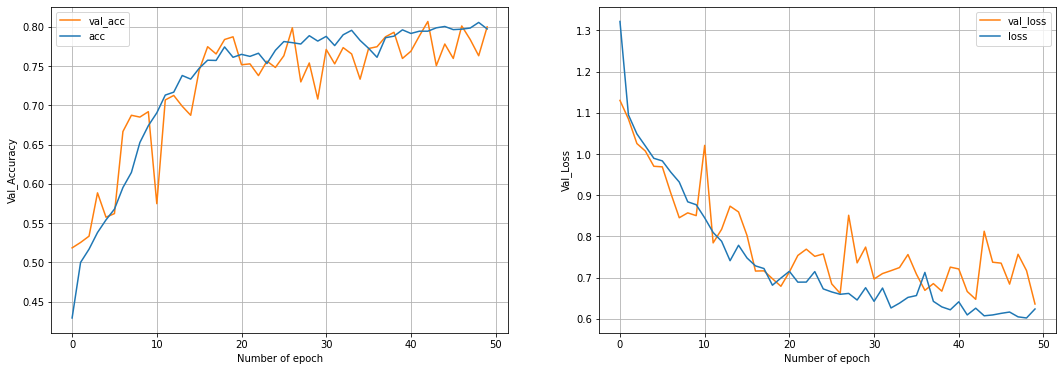

In [ ]:
# evaluate CNN tuned model 12
evaluate_model(history_CNN_tuned_12)

In [ ]:
#  apply dropout 0.25 to each layers except for last one
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  change to apply dropout only to the three layers with the highest parameters
#  apply adam optimizer with default parameters
#  final model comes from model_5
#  training with extra images
def build_final_CNN_model():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_final = build_final_CNN_model()
CNN_model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 128)      

In [ ]:
history_CNN_final, CNN_final_model = train_model(CNN_model_final)

Epoch 1/50
177/177 [==============================] - 2106s 12s/step - loss: 1.4142 - accuracy: 0.3518 - val_loss: 1.1988 - val_accuracy: 0.4345
Epoch 2/50
177/177 [==============================] - 112s 630ms/step - loss: 1.1779 - accuracy: 0.3420 - val_loss: 1.1546 - val_accuracy: 0.3425
Epoch 3/50
177/177 [==============================] - 112s 631ms/step - loss: 1.1439 - accuracy: 0.3447 - val_loss: 1.1344 - val_accuracy: 0.3425
Epoch 4/50
177/177 [==============================] - 111s 629ms/step - loss: 1.1124 - accuracy: 0.4240 - val_loss: 1.0447 - val_accuracy: 0.5096
Epoch 5/50
177/177 [==============================] - 111s 628ms/step - loss: 1.0652 - accuracy: 0.4917 - val_loss: 0.9999 - val_accuracy: 0.5506
Epoch 6/50
177/177 [==============================] - 111s 627ms/step - loss: 0.9859 - accuracy: 0.5435 - val_loss: 0.8875 - val_accuracy: 0.6115
Epoch 7/50
177/177 [==============================] - 111s 628ms/step - loss: 0.9592 - accuracy: 0.5647 - val_loss: 0.8433 - 

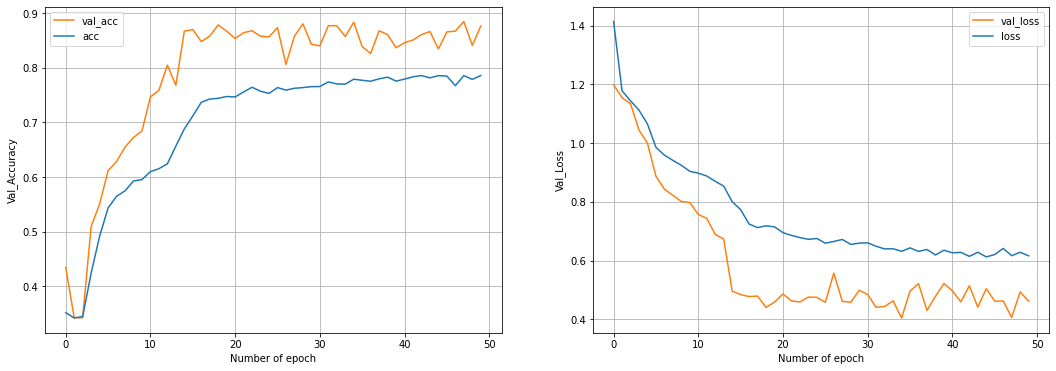

In [ ]:
# evaluate CNN final model
evaluate_model(history_CNN_final)

Using early stop to prevent overfitting

In [ ]:
#  apply regulizer L2 = 0.001 to the three layers with the highest parameters.
#  apply dropout only on the layer with many parameters.
#  final model comes from model_5
#  training with extra images
def build_final_CNN_model_2():
     model = Sequential()
     # layer 1
     model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     # layer 2
     model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 3
     model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Dropout(0.25))
     # layer 4
     model.add(Flatten())
     model.add(Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
     model.add(Dropout(0.25))
     # layer 5
     model.add(Dense(3, activation='softmax'))

     model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])
     return model

In [ ]:
CNN_model_final_2 = build_final_CNN_model_2()
CNN_model_final_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0

In [ ]:
history_CNN_final_2, CNN_final_model_2 = train_model(CNN_model_final_2)

Epoch 1/100
177/177 [==============================] - 2254s 13s/step - loss: 1.3180 - accuracy: 0.4228 - val_loss: 1.1084 - val_accuracy: 0.4904

Epoch 00001: val_loss improved from inf to 1.10843, saving model to /content/drive/My Drive/app/model.h5
Epoch 2/100
177/177 [==============================] - 123s 694ms/step - loss: 1.0393 - accuracy: 0.5466 - val_loss: 0.8891 - val_accuracy: 0.6752

Epoch 00002: val_loss improved from 1.10843 to 0.88910, saving model to /content/drive/My Drive/app/model.h5
Epoch 3/100
177/177 [==============================] - 122s 690ms/step - loss: 0.9672 - accuracy: 0.5859 - val_loss: 0.8790 - val_accuracy: 0.7240

Epoch 00003: val_loss improved from 0.88910 to 0.87902, saving model to /content/drive/My Drive/app/model.h5
Epoch 4/100
177/177 [==============================] - 124s 700ms/step - loss: 0.8957 - accuracy: 0.6477 - val_loss: 0.7493 - val_accuracy: 0.7481

Epoch 00004: val_loss improved from 0.87902 to 0.74928, saving model to /content/drive

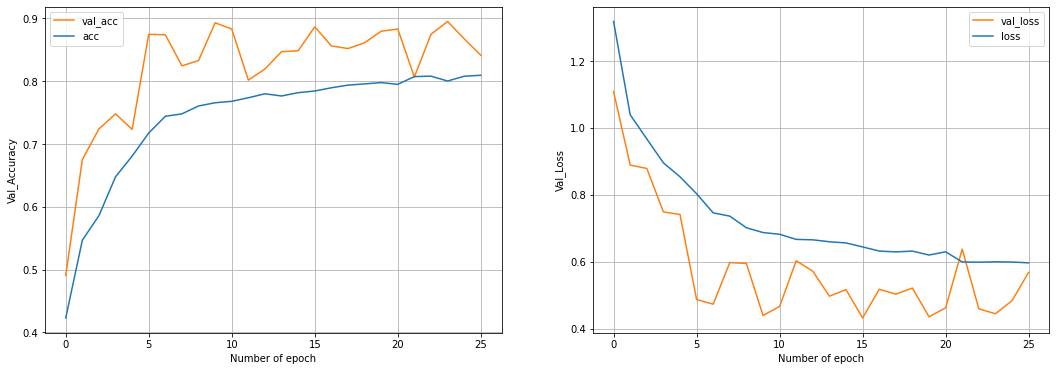

In [ ]:
# evaluate CNN final model 2
evaluate_model(history_CNN_final_2)

In [ ]:
save_model(CNN_final_model_2, 'CNN_model')

Transfer Learning

In [5]:
# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet')

# freeze the convolutional base
base_model.trainable = False

# wrap the model in a sequential model
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

58900480/58889256 [==============================] - 0s 0us/step


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer_learning = model.fit(train, validation_data=test,epochs=15)

Epoch 1/15


In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

history_fineTune = model.fit(train, validation_data=test, initial_epoch=15, epochs=30)

In [ ]:
# Unfreeze some of the pre-trained model and continue training
base_model.trainable = True
for layer in base_model.layers[:3]:
    layer.trainable = False

model.compile(optimizer=RMSprop(learning_rate=3e-6),
              loss='categorical_crossentropy', metrics=['accuracy'])

earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/app/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_fineTune_2 = model.fit(train, validation_data=test, initial_epoch=22, epochs=40, callbacks=[earlyStop, checkPoint])

In [ ]:
acc = history_transfer_learning.history['accuracy']
val_acc = history_transfer_learning.history['val_accuracy']
loss = history_transfer_learning.history['loss']
val_loss = history_transfer_learning.history['val_loss']


acc += history_fineTune.history['accuracy']
val_acc += history_fineTune.history['val_accuracy']
loss += history_fineTune.history['loss']
val_loss += history_fineTune.history['val_loss']

acc += history_fineTune_2.history['accuracy']
val_acc += history_fineTune_2.history['val_accuracy']
loss += history_fineTune_2.history['loss']
val_loss += history_fineTune_2.history['val_loss']

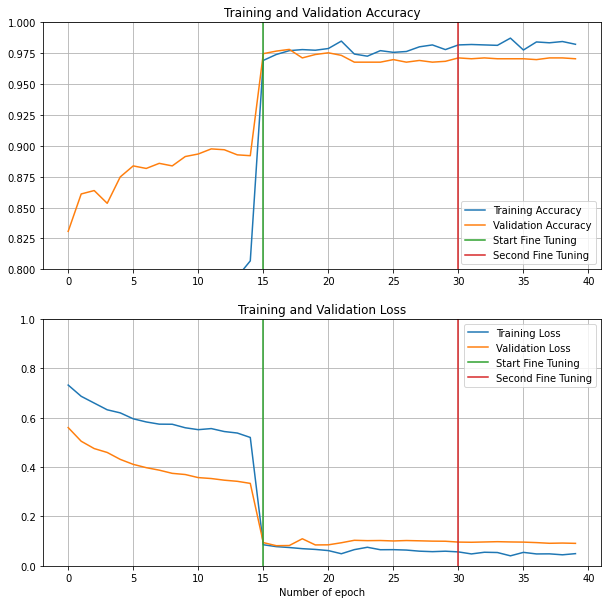

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([15,15],
          plt.ylim(), label='Start Fine Tuning')
plt.ylim([0.8, 1])
plt.plot([30,30],
          plt.ylim(), label='Second Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.grid(True)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([15,15],
         plt.ylim(), label='Start Fine Tuning')
plt.ylim([0, 1.0])
plt.plot([30,30],
         plt.ylim(), label='Second Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Number of epoch')
plt.show()

Second transfer learning

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet')

# freeze the convolutional base
base_model.trainable = False

# wrap the model in a sequential model
transfer_learning_model = Sequential()
transfer_learning_model.add(base_model)
transfer_learning_model.add(tf.keras.layers.GlobalAveragePooling2D())
transfer_learning_model.add(Dropout(0.25))
transfer_learning_model.add(Dense(3, activation='softmax'))


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
transfer_learning_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
transfer_learning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_transfer_learning_2 = transfer_learning_model.fit(train, validation_data=test, epochs=15)

Epoch 1/15
182/182 [==============================] - 2318s 13s/step - loss: 0.4556 - accuracy: 0.8261 - val_loss: 0.2302 - val_accuracy: 0.9312
Epoch 2/15
182/182 [==============================] - 111s 611ms/step - loss: 0.2786 - accuracy: 0.8927 - val_loss: 0.1794 - val_accuracy: 0.9387
Epoch 3/15
182/182 [==============================] - 111s 609ms/step - loss: 0.2417 - accuracy: 0.9129 - val_loss: 0.1734 - val_accuracy: 0.9415
Epoch 4/15
182/182 [==============================] - 111s 610ms/step - loss: 0.2226 - accuracy: 0.9172 - val_loss: 0.1517 - val_accuracy: 0.9484
Epoch 5/15
182/182 [==============================] - 110s 606ms/step - loss: 0.2103 - accuracy: 0.9244 - val_loss: 0.1698 - val_accuracy: 0.9436
Epoch 6/15
182/182 [==============================] - 111s 609ms/step - loss: 0.2016 - accuracy: 0.9245 - val_loss: 0.1560 - val_accuracy: 0.9477
Epoch 7/15
182/182 [==============================] - 111s 608ms/step - loss: 0.1994 - accuracy: 0.9240 - val_loss: 0.1474 - 

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Unfreeze some of the pre-trained model and continue training
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_learning_model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = transfer_learning_model.fit(train, validation_data=test, initial_epoch=15, epochs=30)

Epoch 16/30
182/182 [==============================] - 116s 614ms/step - loss: 0.3231 - accuracy: 0.8850 - val_loss: 0.1452 - val_accuracy: 0.9504
Epoch 17/30
182/182 [==============================] - 111s 609ms/step - loss: 0.2306 - accuracy: 0.9160 - val_loss: 0.1414 - val_accuracy: 0.9566
Epoch 18/30
182/182 [==============================] - 111s 609ms/step - loss: 0.2118 - accuracy: 0.9213 - val_loss: 0.1507 - val_accuracy: 0.9504
Epoch 19/30
182/182 [==============================] - 111s 608ms/step - loss: 0.1883 - accuracy: 0.9338 - val_loss: 0.1303 - val_accuracy: 0.9560
Epoch 20/30
182/182 [==============================] - 110s 607ms/step - loss: 0.1597 - accuracy: 0.9438 - val_loss: 0.1220 - val_accuracy: 0.9642
Epoch 21/30
182/182 [==============================] - 111s 608ms/step - loss: 0.1524 - accuracy: 0.9419 - val_loss: 0.1248 - val_accuracy: 0.9601
Epoch 22/30
182/182 [==============================] - 110s 606ms/step - loss: 0.1457 - accuracy: 0.9460 - val_loss: 0

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

transfer_learning_model.compile(optimizer=RMSprop(learning_rate=3e-6),
              loss='categorical_crossentropy', metrics=['accuracy'])

earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
checkPoint = ModelCheckpoint(filepath='/content/drive/My Drive/app/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_fine_tune_2 = transfer_learning_model.fit(train, validation_data=test, initial_epoch=30, epochs=40, callbacks=[earlyStop,checkPoint])

Epoch 31/40
182/182 [==============================] - 117s 617ms/step - loss: 0.1144 - accuracy: 0.9562 - val_loss: 0.1087 - val_accuracy: 0.9704

Epoch 00031: val_loss improved from inf to 0.10869, saving model to /content/drive/My Drive/app/model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/40
182/182 [==============================] - 112s 614ms/step - loss: 0.1083 - accuracy: 0.9627 - val_loss: 0.1053 - val_accuracy: 0.9683

Epoch 00032: val_loss improved from 0.10869 to 0.10527, saving model to /content/drive/My Drive/app/model.h5
Epoch 33/40
182/182 [==============================] - 111s 611ms/step - loss: 0.0953 - accuracy: 0.9675 - val_loss: 0.1060 - val_accuracy: 0.9690

Epoch 00033: val_loss did not improve from 0.10527
Epoch 34/40
182/182 [==============================] - 111s 612ms/step - loss: 0.0857 - accuracy: 0.9708 - val_loss: 0.1015 - val_accuracy: 0.9718

Epoch 00034: val_loss improved from 0.10527 to 0.10149, saving model to /content/drive/My Drive/app/model.h5
Epoch 35/40
182/182 [==============================] - 111s 611ms/step - loss: 0.0824 - accuracy: 0.9739 - val_loss: 0.1011 - val_accuracy: 0.9725

Epoch 00035: val_loss improved from 0.10149 to 0.10107, saving model to /content/drive/My Drive/app/model.h5
Epoch 36/40
182/182 [=========

In [ ]:
acc = history_transfer_learning_2.history['accuracy']
val_acc = history_transfer_learning_2.history['val_accuracy']
loss = history_transfer_learning_2.history['loss']
val_loss = history_transfer_learning_2.history['val_loss']


acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']
loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

acc += history_fine_tune_2.history['accuracy']
val_acc += history_fine_tune_2.history['val_accuracy']
loss += history_fine_tune_2.history['loss']
val_loss += history_fine_tune_2.history['val_loss']

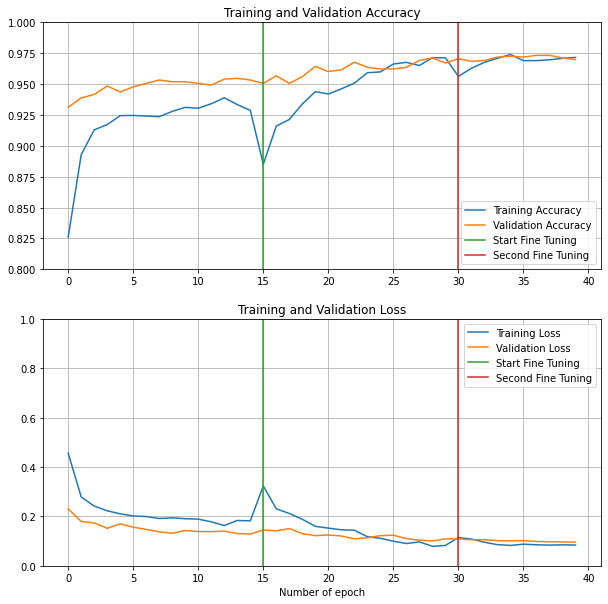

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.grid(True)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([15,15],
          plt.ylim(), label='Start Fine Tuning')
plt.ylim([0.8, 1])
plt.plot([30,30],
          plt.ylim(), label='Second Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.grid(True)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([15,15],
         plt.ylim(), label='Start Fine Tuning')
plt.ylim([0, 1.0])
plt.plot([30,30],
         plt.ylim(), label='Second Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Number of epoch')
plt.show()

In [ ]:
save_model(transfer_learning_model,'transfer_learning_model')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved Successfully.


Test

In [ ]:
# Import modules for test
from tensorflow.keras.models import load_model

In [ ]:
MLP = load_model(model_save_dir + 'MLP_model.h5')
CNN_final = load_model(model_save_dir + 'CNN_model.h5')
tl_model = load_model('/content/drive/My Drive/app/model.h5')

In [ ]:
print("Loss and Accuracy of MLP model:")
loss, accuracy = MLP.evaluate(testdata)

Loss and Accuracy of MLP model:
148/148 [==============================] - 83s 565ms/step - loss: 1.0932 - accuracy: 0.3919


In [ ]:
print("Loss and Accuracy of optimize CNN model:")
loss, accuracy = CNN_final.evaluate(testdata)

Loss and Accuracy of optimize CNN model:
148/148 [==============================] - 1s 4ms/step - loss: 0.3129 - accuracy: 0.9392


In [ ]:
print("Loss and Accuracy of transfer learning model:")
loss, accuracy = tl_model.evaluate(testdata)

Loss and Accuracy of transfer learning model:
148/148 [==============================] - 2s 8ms/step - loss: 0.0851 - accuracy: 0.9730
